In [11]:
%load_ext autoreload
%autoreload 2

In [12]:
from aeml.models.gbdt.run import run_model
from aeml.models.gbdt.settings import *
from aeml.models.gbdt.plot import make_forecast_plot
from aeml.utils.io import dump_pickle

In [13]:
from darts import TimeSeries
import pandas as pd
import matplotlib.pyplot as plt
from darts.dataprocessing.transformers import Scaler

MEAS_COLUMNS = [
    "TI-19",
    #      "FI-16",
    #     "TI-33",
    #     "FI-2",
    #     "FI-151",
    #     "TI-8",
    #     "FI-241",
    #  "valve-position-12",  # dry-bed
    #     "FI-38",  # strippera
    #     "PI-28",  # stripper
    #     "TI-28",  # stripper
    #      "FI-20",
    #     "FI-30",
    "TI-3",
    "FI-19",
    #     "FI-211",
    "FI-11",
    #     "TI-30",
    #     "PI-30",
    "TI-1213",
    #     "TI-4",
    #    "FI-23",
    #    "FI-20",
    #   "FI-20/FI-23",
    #    "TI-22",
    #"delta_t",
    "TI-35",
    #     "delta_t_2"
]

TARGETS_clean = ['2-Amino-2-methylpropanol C4H11NO', 'Piperazine C4H10N2', 
                 "Carbon dioxide CO2", "Ammonia NH3"]



In [14]:
import time
timestr = time.strftime("%Y%m%d-%H%M%S") + '_6_filtered'

In [15]:
from aeml.preprocessing.transform import transform_data
from aeml.preprocessing.resample import resample_regular

In [16]:
import matplotlib.pyplot as plt
plt.style.reload_library()
plt.style.use('science')
from matplotlib import rcParams
rcParams['font.family'] = 'sans-serif'
import datetime as dt
import numpy as np

In [17]:
df = pd.read_pickle('20220210_smooth_window_16.pkl')

In [18]:
TARGETS_clean = ['2-Amino-2-methylpropanol C4H11NO', 'Piperazine C4H10N2']

In [19]:
def choose_index(series, fraction):
    timestamps = series.time_index
    fraction_index = int(len(timestamps) * fraction)

    return timestamps[fraction_index]


def split_data(x, y, targets, fraction_train, fraction_test=0.5):
    ts = choose_index(x, fraction_train)
    x_before, x_after = x.split_before(ts)
    y_before, y_after = y.split_before(ts)

    ts_2 = choose_index(x_after, fraction_test)

    print(ts_2)
    x_valid, x_test = x_after.split_before(ts_2)
    y_valid, y_test = y_after.split_before(ts_2)

    return (
        (x_before, y_before[targets]),
        (x_valid, y_valid[targets]),
        (x_test, y_test[targets]),
        ts, ts_2
    )


In [23]:
def get_data(num_outputs, targets):
    train, valid, test, ts, ts_2 = split_data(X, Y, targets, 0.5)
    return (train, valid, test, ts, ts_2)


In [63]:
step = 30
target = 0


quantiles = (0.1, 0.5, 0.9)

Y = TimeSeries.from_dataframe(df, value_cols=TARGETS_clean)
X = TimeSeries.from_dataframe(df, value_cols=MEAS_COLUMNS)
train, valid, test, ts, ts_2 = get_data(1, [TARGETS_clean[target]])


x_scaler = Scaler(name='x')
y_scaler = Scaler(name='y')

x_train = x_scaler.fit_transform(train[0])
x_valid = x_scaler.transform(valid[0])
x_test = x_scaler.transform(test[0])

y_train= y_scaler.fit_transform(train[1])
y_valid = y_scaler.transform(valid[1])
y_test = y_scaler.transform(test[1])


x_connected = TimeSeries.from_dataframe(pd.concat([x_train.pd_dataframe(), x_valid.pd_dataframe(), x_test.pd_dataframe()]))

y_connected = TimeSeries.from_dataframe(pd.concat([y_train.pd_dataframe(), y_valid.pd_dataframe(), y_test.pd_dataframe()]))



model = run_model(x_train, y_train, quantiles=quantiles, **settings_30_0, output_chunk_length=step)

2022-03-11 10:10:44.560 | INFO     | aeml.models.gbdt.gbmquantile:fit:17 - fitting model lower percentile


2010-01-06 15:12:00
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] bagging_fraction is set=0.9886355937008238, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9886355937008238


/home/kjablonk/anaconda3/envs/aeml/lib/python3.8/site-packages/darts/timeseries.py:3283: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  if isinstance(time_idx, pd.Int64Index) and not isinstance(
2022-03-11 10:11:35.165 | INFO     | aeml.models.gbdt.gbmquantile:fit:17 - fitting model middle percentile
/home/kjablonk/anaconda3/envs/aeml/lib/python3.8/site-packages/darts/timeseries.py:3283: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  if isinstance(time_idx, pd.Int64Index) and not isinstance(
2022-03-11 10:12:28.540 | INFO     | aeml.models.gbdt.gbmquantile:fit:17 - fitting model upper percentile
/home/kjablonk/anaconda3/envs/aeml/lib/python3.8/site-packages/darts/timeseries.py:3283: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future v

In [64]:
forecasts = model.historical_forecasts(series=y_connected, past_covariates=x_connected, retrain=False, start=0.2, forecast_horizon=step)

In [65]:
dump_pickle(f'{timestr}-{step}-step-target-{target}-forecasts_quantiles_{quantiles[0]}_{quantiles[-1]}.pkl', forecasts)

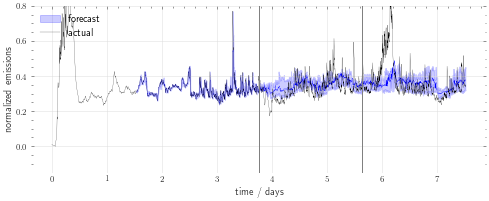

In [66]:
make_forecast_plot(y_connected, forecasts[0].pd_dataframe(), forecasts[1].pd_dataframe(), forecasts[2].pd_dataframe(), target=target, outname=f'{timestr}-{step}-step-target-{target}_quantiles_{quantiles[0]}_{quantiles[-1]}.pdf')

In [61]:
TARGETS_clean[target]

'Piperazine C4H10N2'

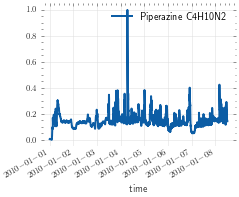

In [62]:
y_connected[TARGETS_clean[target]].plot()